In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from nilearn import datasets

os.environ["NILEARN_SHARED_DATA"] = "~/shared/data/nilearn_data"
datasets.get_data_dirs()

['~/shared/data/nilearn_data', '/Users/emdupre/nilearn_data']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import (datasets, maskers, plotting)
from nilearn.connectome import ConnectivityMeasure
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

development_dataset = datasets.fetch_development_fmri()
msdl_atlas = datasets.fetch_atlas_msdl()

masker = maskers.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()
correlation_measure = ConnectivityMeasure(kind='correlation')

pooled_subjects = []
groups = []  # child or adult

for func_file, confound_file, (_, phenotypic) in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic.iterrows()):

    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    groups.append(phenotypic['Child_Adult'])

_, classes = np.unique(groups, return_inverse=True)
pooled_subjects = np.asarray(pooled_subjects)

[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri
[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri/development_fmri
[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri/development_fmri
[fetch_atlas_msdl] Dataset found in /Users/emdupre/nilearn_data/msdl_atlas


In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
# First, re-generate our cross-validation scores for StratifiedShuffleSplit

strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=30)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    strat_scores.append(accuracy_score(classes[test], predictions))

print(f'StratifiedShuffleSplit Accuracy: {np.mean(strat_scores):.2f} ± {np.std(strat_scores):.2f}')

StratifiedShuffleSplit Accuracy: 0.95 ± 0.02


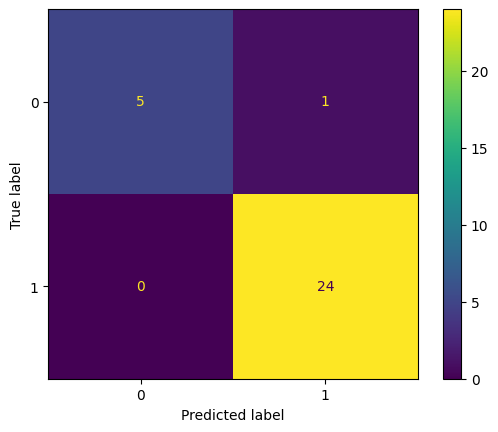

In [5]:
# Then, generate a confusion matrix for the trained classifier
# We'll plot just the last CV fold for now
cm = ConfusionMatrixDisplay.from_predictions(classes[test], predictions)

In [6]:
# Then, compare with cross-validation scores for ShuffleSplit

from sklearn.model_selection import KFold
kfold_scores = []

cv = KFold(n_splits=5)
for train, ktest in cv.split(pooled_subjects):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    kfold_predictions = classifier.predict(
        connectivity.transform(pooled_subjects[ktest]))
    kfold_scores.append(accuracy_score(classes[ktest], kfold_predictions))

print(f'KFold Accuracy: {np.mean(kfold_scores):.2f} ± {np.std(kfold_scores):.2f}')

KFold Accuracy: 0.77 ± 0.39


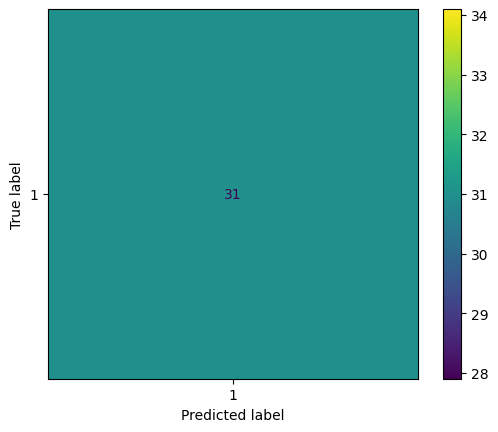

In [7]:
# Then, generate a confusion matrix for the trained classifier
# We'll plot just the last CV fold for now
cm = ConfusionMatrixDisplay.from_predictions(classes[ktest], kfold_predictions)

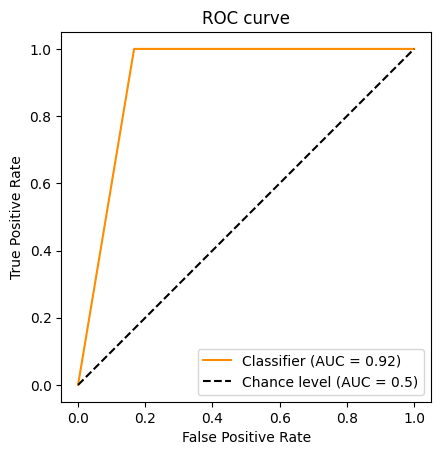

In [8]:
from sklearn.metrics import auc, RocCurveDisplay

RocCurveDisplay.from_predictions(
    classes[test],
    predictions,
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

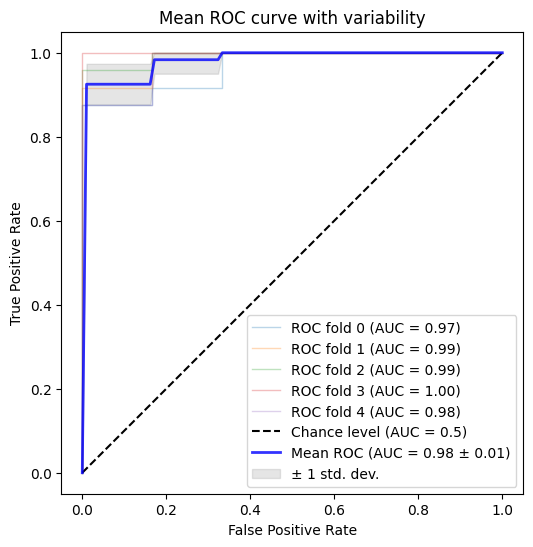

In [9]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=30)

for fold, (train, test) in enumerate(cv.split(pooled_subjects, groups)):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        connectivity.transform(pooled_subjects[test]),
        classes[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == 4),  # n_splits - 1
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = %0.2f ± %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"± 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
# med test set StratifiedShuffleSplit

med_strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=15)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    med_strat_scores.append(accuracy_score(classes[test], predictions))

print(f'Medium StratifiedShuffleSplit Accuracy: {np.mean(med_strat_scores):.2f} ± {np.std(med_strat_scores):.2f}')

Medium StratifiedShuffleSplit Accuracy: 0.92 ± 0.05


In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
# small test set StratifiedShuffleSplit

small_strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=5)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    small_strat_scores.append(accuracy_score(classes[test], predictions))

print(f'Small StratifiedShuffleSplit Accuracy: {np.mean(small_strat_scores):.2f} ± {np.std(small_strat_scores):.2f}')

Small StratifiedShuffleSplit Accuracy: 0.92 ± 0.10


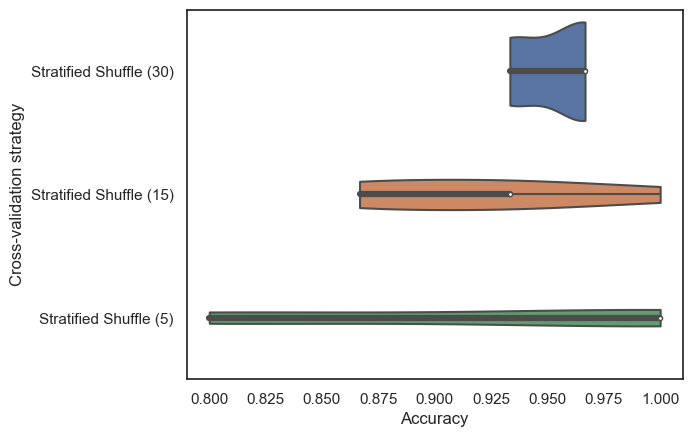

In [12]:
import seaborn as sns
sns.set_theme(style='white')

ax = sns.violinplot(
    data=[strat_scores, med_strat_scores, small_strat_scores], 
    orient='h', 
    cut=0
)
ax.set(
    yticklabels=[
        'Stratified Shuffle (30)', 
        'Stratified Shuffle (15)', 
        'Stratified Shuffle (5)'
    ],
    ylabel='Cross-validation strategy',
    xlabel='Accuracy'
);

In [13]:
# Compare with cross-validation scores for leave-one-subject-out

from sklearn.model_selection import LeaveOneOut
loo_scores = []

cv = LeaveOneOut()
for train, test in cv.split(pooled_subjects):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    loo_scores.append(accuracy_score(classes[test], predictions))

print(f'Leave-One-Out Accuracy: {np.mean(loo_scores):.2f} ± {np.std(loo_scores):.2f}')

Leave-One-Out Accuracy: 0.95 ± 0.21
